In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2

**Load and normalize the data**

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [3]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [4]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [5]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [6]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [8]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
input_size = (3, 224, 224)
summary(model_res, input_size, device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [11]:
start_time = time.time()

In [12]:
epochs = 25
patience = 3
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  4%|▍         | 1/25 [01:42<41:02, 102.62s/it]

Epoch 1
Training Loss: 1.121525831077758 
Training Accuracy: 59.4078628053713%
Validation Loss: 1.7536410130271616 
Validation Accuracy: 56.41481960847759%
Validation Loss Decreased(inf--->1.753641) 
Saving The Model


  8%|▊         | 2/25 [03:24<39:10, 102.17s/it]

Epoch 2
Training Loss: 0.7395636060826231 
Training Accuracy: 72.69050315482932%
Validation Loss: 0.7499986260898354 
Validation Accuracy: 73.2648438763954%
Validation Loss Decreased(1.753641--->0.749999) 
Saving The Model


 12%|█▏        | 3/25 [05:05<37:13, 101.52s/it]

Epoch 3
Training Loss: 0.6201297711648375 
Training Accuracy: 77.35803268079599%
Validation Loss: 0.9875603703257342 
Validation Accuracy: 67.48907943698431%


 16%|█▌        | 4/25 [06:47<35:37, 101.78s/it]

Epoch 4
Training Loss: 0.5150033055734881 
Training Accuracy: 81.2328102248827%
Validation Loss: 0.5559162852144981 
Validation Accuracy: 79.45316291862159%
Validation Loss Decreased(0.749999--->0.555916) 
Saving The Model


 20%|██        | 5/25 [08:29<33:57, 101.87s/it]

Epoch 5
Training Loss: 0.4543954798186472 
Training Accuracy: 83.83756673677398%
Validation Loss: 0.4204360547761892 
Validation Accuracy: 84.63031871865394%
Validation Loss Decreased(0.555916--->0.420436) 
Saving The Model


 24%|██▍       | 6/25 [10:11<32:17, 101.97s/it]

Epoch 6
Training Loss: 0.4066828322580002 
Training Accuracy: 85.23701666397024%
Validation Loss: 0.8750354715403968 
Validation Accuracy: 73.08687914576929%


 28%|██▊       | 7/25 [11:53<30:37, 102.11s/it]

Epoch 7
Training Loss: 0.36715993050302953 
Training Accuracy: 86.59602006147873%
Validation Loss: 0.4203766478509558 
Validation Accuracy: 85.3745348649086%
Validation Loss Decreased(0.420436--->0.420377) 
Saving The Model


 32%|███▏      | 8/25 [13:36<28:56, 102.13s/it]

Epoch 8
Training Loss: 0.32697751492415905 
Training Accuracy: 87.80132664617376%
Validation Loss: 0.49708222875068353 
Validation Accuracy: 82.08218734832552%


 36%|███▌      | 9/25 [15:16<27:07, 101.69s/it]

Epoch 9
Training Loss: 0.29680497228175173 
Training Accuracy: 89.41918783368386%
Validation Loss: 0.313429631167681 
Validation Accuracy: 88.76395405274228%
Validation Loss Decreased(0.420377--->0.313430) 
Saving The Model


 40%|████      | 10/25 [16:58<25:26, 101.73s/it]

Epoch 10
Training Loss: 0.27585286274552345 
Training Accuracy: 90.32519009868953%
Validation Loss: 0.26460085104602254 
Validation Accuracy: 90.5921371946287%
Validation Loss Decreased(0.313430--->0.264601) 
Saving The Model


 44%|████▍     | 11/25 [18:40<23:46, 101.88s/it]

Epoch 11
Training Loss: 0.25680560509864364 
Training Accuracy: 91.03704902119398%
Validation Loss: 0.30653094294305305 
Validation Accuracy: 89.2816696327455%


 48%|████▊     | 12/25 [20:22<22:02, 101.76s/it]

Epoch 12
Training Loss: 0.22024408683604357 
Training Accuracy: 92.37987380682738%
Validation Loss: 0.22451826558960963 
Validation Accuracy: 91.94305128619965%
Validation Loss Decreased(0.264601--->0.224518) 
Saving The Model


 52%|█████▏    | 13/25 [22:04<20:22, 101.88s/it]

Epoch 13
Training Loss: 0.20119525249614273 
Training Accuracy: 93.09982203526937%
Validation Loss: 0.26343441408040913 
Validation Accuracy: 91.19883513994499%


 56%|█████▌    | 14/25 [23:45<18:37, 101.60s/it]

Epoch 14
Training Loss: 0.18947013515680644 
Training Accuracy: 93.46384080245915%
Validation Loss: 0.2869682669836922 
Validation Accuracy: 90.85908429056786%


 60%|██████    | 15/25 [25:27<16:58, 101.82s/it]

Epoch 15
Training Loss: 0.17515731995650966 
Training Accuracy: 93.4881087202718%
Validation Loss: 0.2063243214079499 
Validation Accuracy: 92.96230383433101%
Validation Loss Decreased(0.224518--->0.206324) 
Saving The Model


 64%|██████▍   | 16/25 [27:09<15:15, 101.68s/it]

Epoch 16
Training Loss: 0.1670167128668583 
Training Accuracy: 94.07053874777544%
Validation Loss: 0.25451444814255997 
Validation Accuracy: 91.61947904869763%


 68%|██████▊   | 17/25 [28:51<13:34, 101.85s/it]

Epoch 17
Training Loss: 0.15940282408518655 
Training Accuracy: 94.24850347840156%
Validation Loss: 0.19155468279134857 
Validation Accuracy: 93.59326969745996%
Validation Loss Decreased(0.206324--->0.191555) 
Saving The Model


 72%|███████▏  | 18/25 [30:33<11:53, 101.98s/it]

Epoch 18
Training Loss: 0.13992974764693922 
Training Accuracy: 95.15450574340721%
Validation Loss: 0.1928680132814618 
Validation Accuracy: 93.61753761527261%


 76%|███████▌  | 19/25 [32:15<10:12, 102.04s/it]

Epoch 19
Training Loss: 0.12789140671048824 
Training Accuracy: 95.38909561559618%
Validation Loss: 0.14575683176565618 
Validation Accuracy: 95.18686296715742%
Validation Loss Decreased(0.191555--->0.145757) 
Saving The Model


 80%|████████  | 20/25 [33:58<08:30, 102.15s/it]

Epoch 20
Training Loss: 0.11374705228040077 
Training Accuracy: 96.02815078466267%
Validation Loss: 0.12330789923985568 
Validation Accuracy: 95.78547160653616%
Validation Loss Decreased(0.145757--->0.123308) 
Saving The Model


 84%|████████▍ | 21/25 [35:40<06:48, 102.10s/it]

Epoch 21
Training Loss: 0.13736497126375288 
Training Accuracy: 95.51043520465944%
Validation Loss: 0.21845018434475444 
Validation Accuracy: 92.97039314026857%


 88%|████████▊ | 22/25 [37:22<05:06, 102.04s/it]

Epoch 22
Training Loss: 0.10938199015469013 
Training Accuracy: 96.32745510435204%
Validation Loss: 0.13419536457851874 
Validation Accuracy: 95.5832389580974%


100%|██████████| 25/25 [39:04<00:00, 93.77s/it] 

Epoch 23
Training Loss: 0.10119593310415341 
Training Accuracy: 96.3679016340398%
Validation Loss: 0.1419500463187348 
Validation Accuracy: 95.14641643746967%


-------------------------------------------------------
Best models accuracy 96.05241870247532
-------------------------------------------------------


In [13]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 39.30 minutes


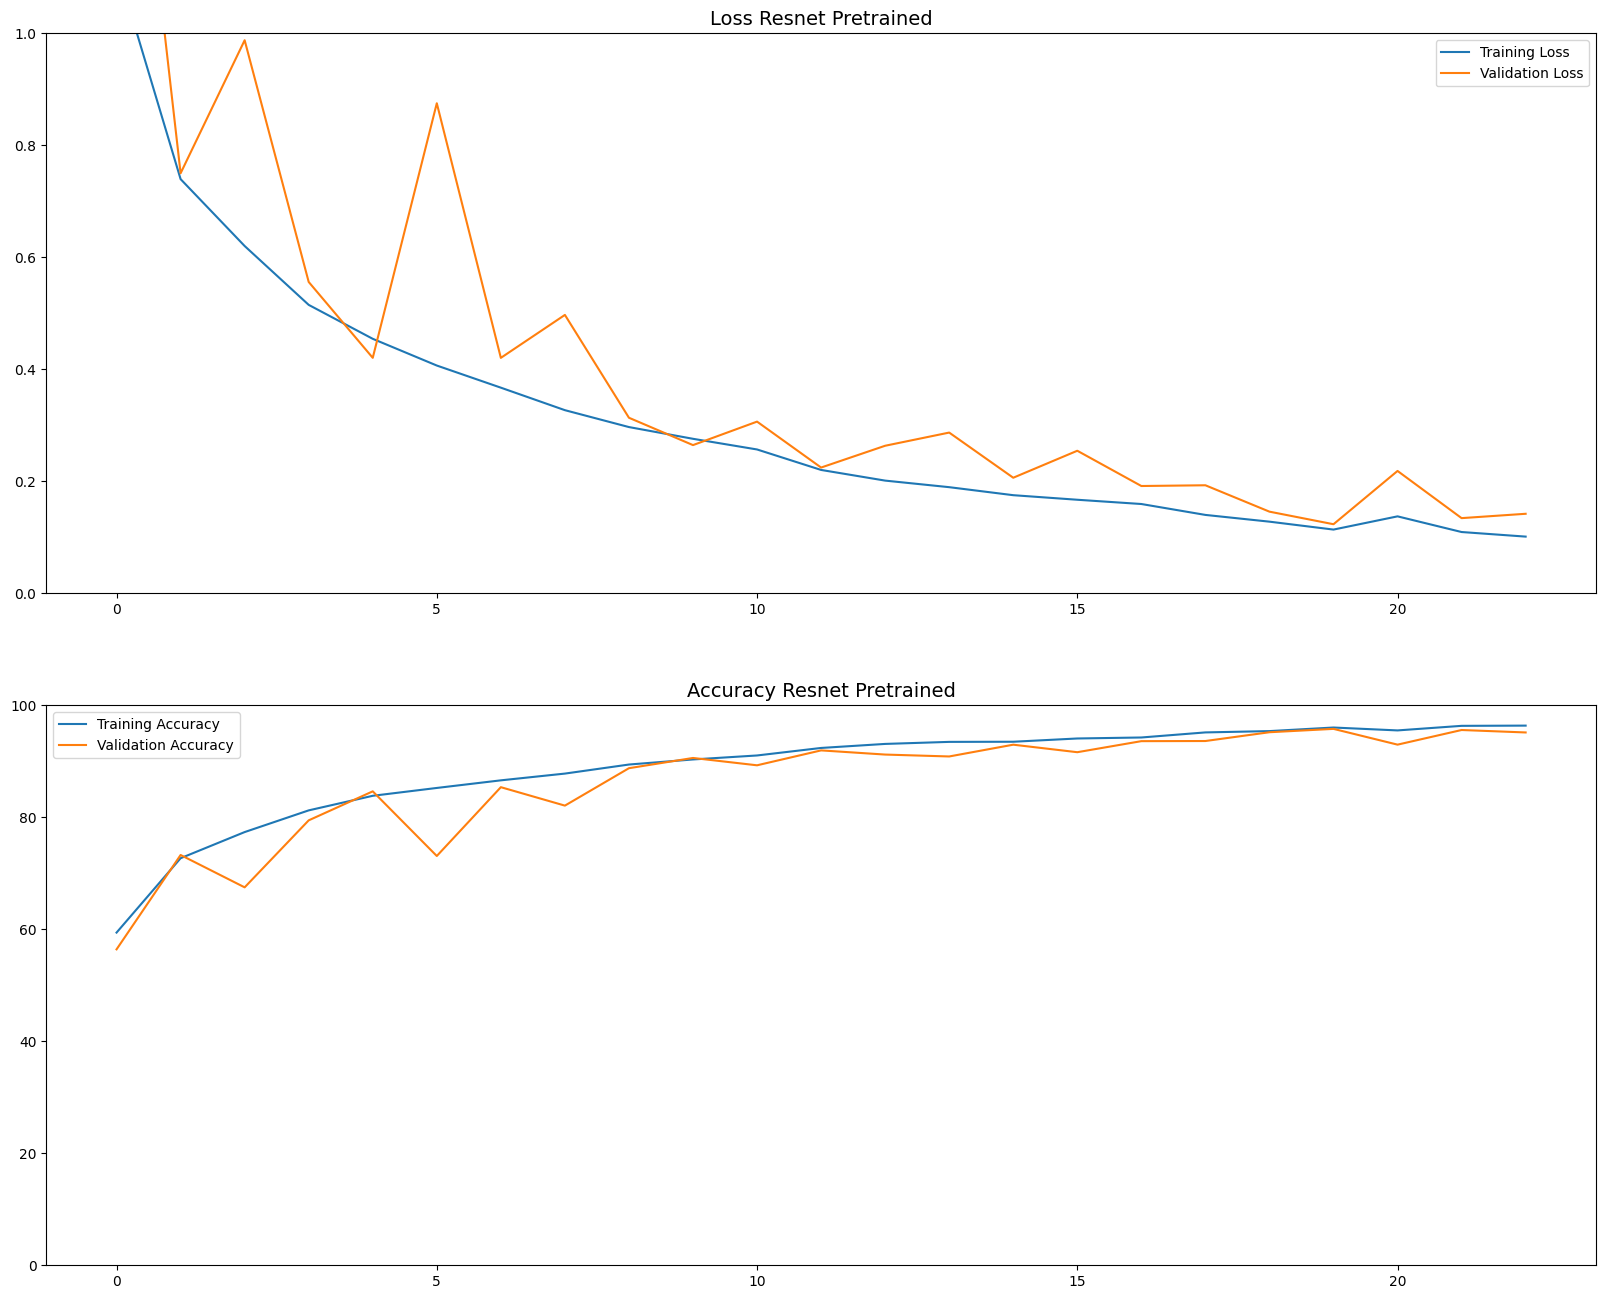

In [20]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

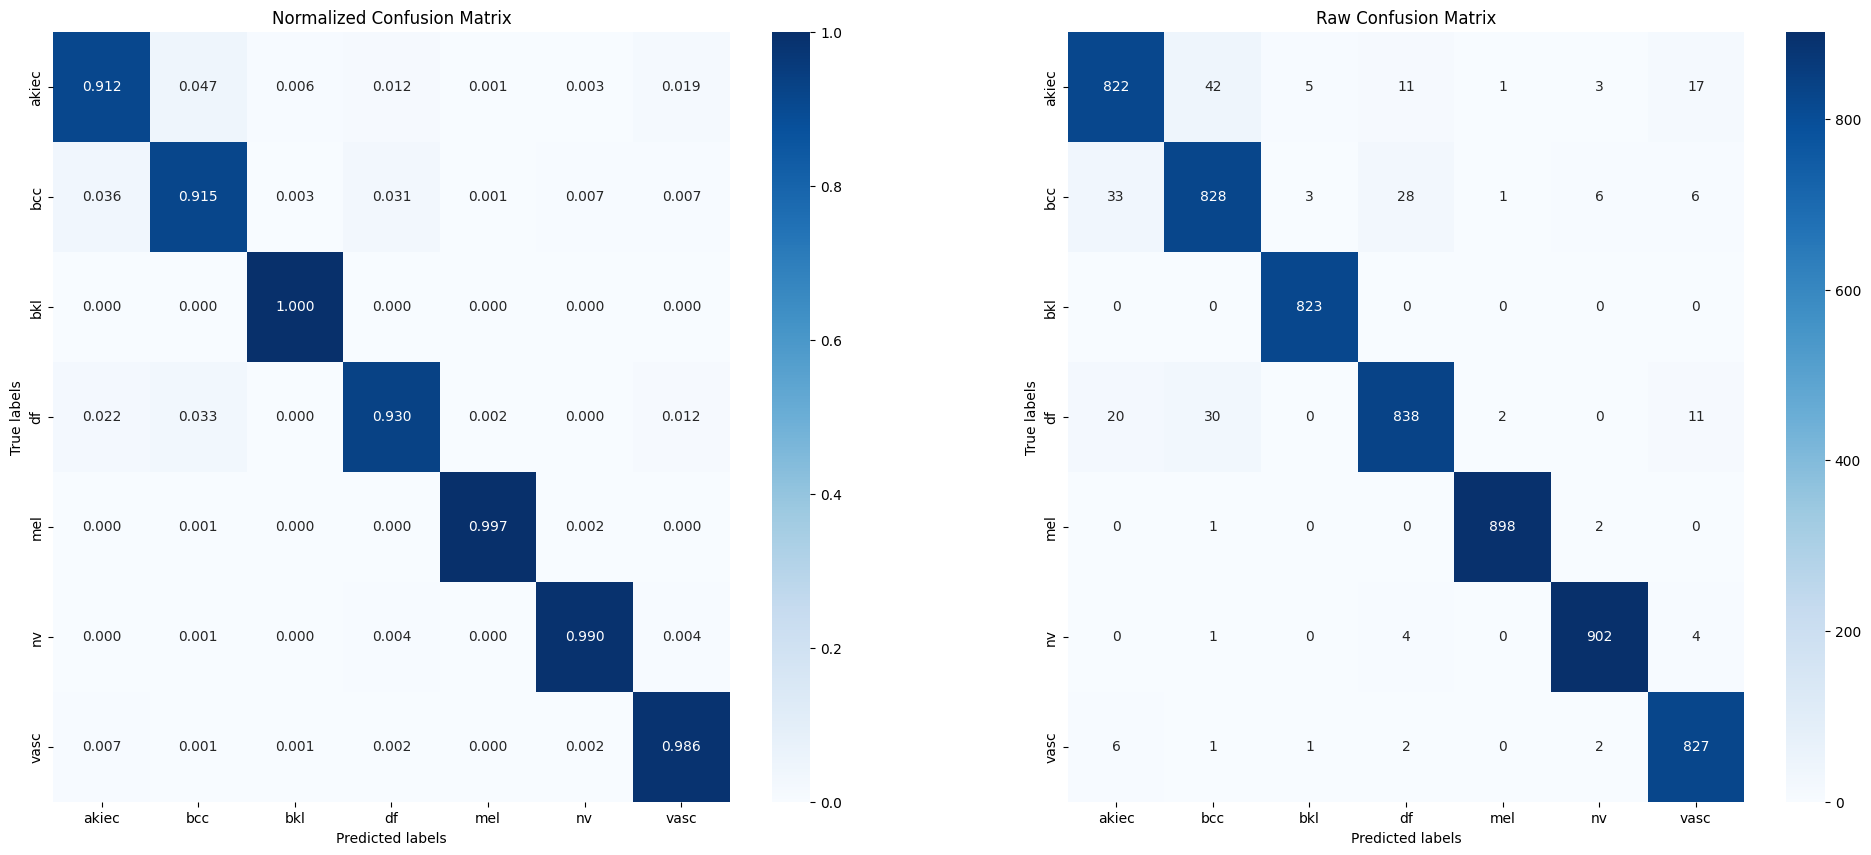

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

       akiec       0.93      0.91      0.92       901
         bcc       0.92      0.91      0.92       905
         bkl       0.99      1.00      0.99       823
          df       0.95      0.93      0.94       901
         mel       1.00      1.00      1.00       901
          nv       0.99      0.99      0.99       911
        vasc       0.96      0.99      0.97       839

    accuracy                           0.96      6181
   macro avg       0.96      0.96      0.96      6181
weighted avg       0.96      0.96      0.96      6181

-------------------------------------------------------


In [15]:
Model_functions.conf_report(resnet_model, test_loader, 'resnet_conf_mat')

In [17]:
best_model_state = torch.load('resnet_pret.pth')
model_res.load_state_dict(best_model_state)
test_accuracy = Model_functions.test_model(model_res, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 95.90681119559942
-------------------------------------------------------


In [16]:
import gc
torch.cuda.empty_cache() 
gc.collect()

994

# **Densenet**

In [8]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [10]:
input_size = (3, 224, 224)
summary(model_des, input_size, device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [11]:
start_time = time.time()

In [12]:
epochs = 25
patience = 3
model_filename = 'densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  4%|▍         | 1/25 [01:54<45:49, 114.55s/it]

Epoch 1
Training Loss: 0.8298948320923542 
Training Accuracy: 70.1423717845009%
Validation Loss: 0.5827826007007012 
Validation Accuracy: 78.67658954861673%
Validation Loss Decreased(inf--->0.582783) 
Saving The Model


  8%|▊         | 2/25 [03:48<43:46, 114.19s/it]

Epoch 2
Training Loss: 0.5488676731823643 
Training Accuracy: 80.25400420643909%
Validation Loss: 0.47933261606659383 
Validation Accuracy: 83.06908267270668%
Validation Loss Decreased(0.582783--->0.479333) 
Saving The Model


 12%|█▏        | 3/25 [05:41<41:38, 113.57s/it]

Epoch 3
Training Loss: 0.44574417087227797 
Training Accuracy: 83.92654910208704%
Validation Loss: 0.42407943479697524 
Validation Accuracy: 84.18540689208866%
Validation Loss Decreased(0.479333--->0.424079) 
Saving The Model


 16%|█▌        | 4/25 [07:35<39:47, 113.71s/it]

Epoch 4
Training Loss: 0.36070455031262505 
Training Accuracy: 86.60410936741627%
Validation Loss: 0.4384252071111085 
Validation Accuracy: 84.84064067303025%


 20%|██        | 5/25 [09:29<37:54, 113.75s/it]

Epoch 5
Training Loss: 0.31100116845326214 
Training Accuracy: 88.78822197055493%
Validation Loss: 0.3144606165106598 
Validation Accuracy: 88.22197055492639%
Validation Loss Decreased(0.424079--->0.314461) 
Saving The Model


 24%|██▍       | 6/25 [11:22<36:01, 113.77s/it]

Epoch 6
Training Loss: 0.2747315784449417 
Training Accuracy: 90.13104675618833%
Validation Loss: 0.2614851678969478 
Validation Accuracy: 90.66494094806666%
Validation Loss Decreased(0.314461--->0.261485) 
Saving The Model


 28%|██▊       | 7/25 [13:16<34:08, 113.82s/it]

Epoch 7
Training Loss: 0.25327585642382466 
Training Accuracy: 91.02087040931887%
Validation Loss: 0.25581847622663323 
Validation Accuracy: 90.43844038181524%
Validation Loss Decreased(0.261485--->0.255818) 
Saving The Model


 32%|███▏      | 8/25 [15:10<32:14, 113.82s/it]

Epoch 8
Training Loss: 0.22038780323660498 
Training Accuracy: 91.97540850994984%
Validation Loss: 0.19233074771043018 
Validation Accuracy: 93.65798414496037%
Validation Loss Decreased(0.255818--->0.192331) 
Saving The Model


 36%|███▌      | 9/25 [17:04<30:20, 113.77s/it]

Epoch 9
Training Loss: 0.19580407168485167 
Training Accuracy: 93.26969745995794%
Validation Loss: 0.18861599937707033 
Validation Accuracy: 93.6498948390228%
Validation Loss Decreased(0.192331--->0.188616) 
Saving The Model


 40%|████      | 10/25 [18:58<28:27, 113.81s/it]

Epoch 10
Training Loss: 0.18556359901696984 
Training Accuracy: 93.65798414496037%
Validation Loss: 0.17946329786747847 
Validation Accuracy: 93.3910370490212%
Validation Loss Decreased(0.188616--->0.179463) 
Saving The Model


 44%|████▍     | 11/25 [20:51<26:32, 113.74s/it]

Epoch 11
Training Loss: 0.1544518745961558 
Training Accuracy: 94.8471121177803%
Validation Loss: 0.20023819657393974 
Validation Accuracy: 93.30205468370814%


 48%|████▊     | 12/25 [22:45<24:39, 113.80s/it]

Epoch 12
Training Loss: 0.15710890073887523 
Training Accuracy: 94.62061155152888%
Validation Loss: 0.16203788302607777 
Validation Accuracy: 94.50736126840317%
Validation Loss Decreased(0.179463--->0.162038) 
Saving The Model


 52%|█████▏    | 13/25 [24:39<22:45, 113.78s/it]

Epoch 13
Training Loss: 0.13615412459749662 
Training Accuracy: 95.16259504934477%
Validation Loss: 0.11116345104754202 
Validation Accuracy: 96.34363371622715%
Validation Loss Decreased(0.162038--->0.111163) 
Saving The Model


 56%|█████▌    | 14/25 [26:33<20:51, 113.77s/it]

Epoch 14
Training Loss: 0.1294267826042203 
Training Accuracy: 95.6317747937227%
Validation Loss: 0.1181474291365738 
Validation Accuracy: 96.30318718653939%


 60%|██████    | 15/25 [28:26<18:57, 113.73s/it]

Epoch 15
Training Loss: 0.12499983528104325 
Training Accuracy: 95.6317747937227%
Validation Loss: 0.150014736735351 
Validation Accuracy: 94.9280051771558%


 64%|██████▍   | 16/25 [30:20<17:04, 113.80s/it]

Epoch 16
Training Loss: 0.1104306522371772 
Training Accuracy: 96.14949037372594%
Validation Loss: 0.09297277931321306 
Validation Accuracy: 96.76427762497978%
Validation Loss Decreased(0.111163--->0.092973) 
Saving The Model


 68%|██████▊   | 17/25 [32:14<15:10, 113.78s/it]

Epoch 17
Training Loss: 0.08880012681273364 
Training Accuracy: 96.65102734185407%
Validation Loss: 0.11313046317593284 
Validation Accuracy: 96.10904384403818%


 72%|███████▏  | 18/25 [34:08<13:16, 113.75s/it]

Epoch 18
Training Loss: 0.10323614072179764 
Training Accuracy: 96.34363371622715%
Validation Loss: 0.1616874940507475 
Validation Accuracy: 94.82284419996765%


100%|██████████| 25/25 [36:01<00:00, 86.48s/it] 

Epoch 19
Training Loss: 0.10069530828403506 
Training Accuracy: 96.47306261122796%
Validation Loss: 0.09834530226012707 
Validation Accuracy: 96.54586636466591%


-------------------------------------------------------
Best models accuracy 96.99077819123119
-------------------------------------------------------


In [13]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 36.28 minutes


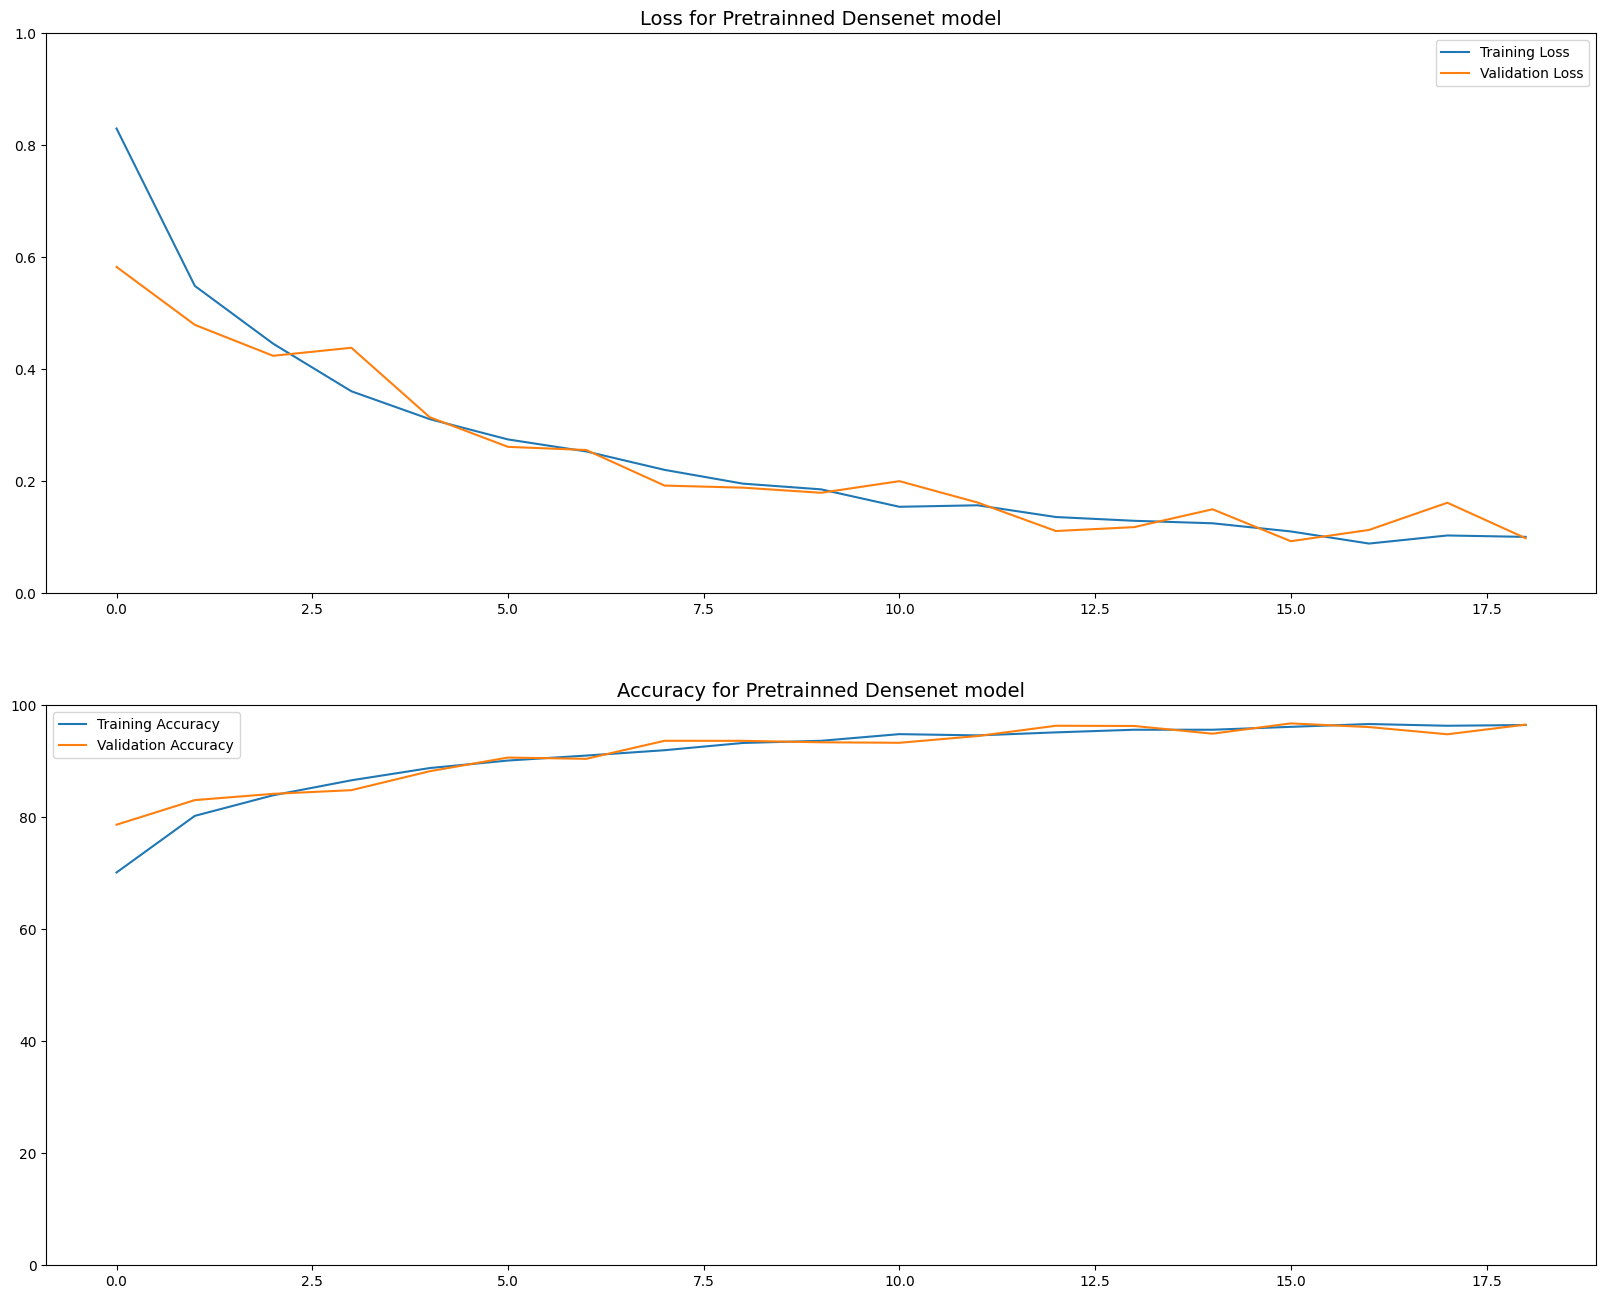

In [14]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

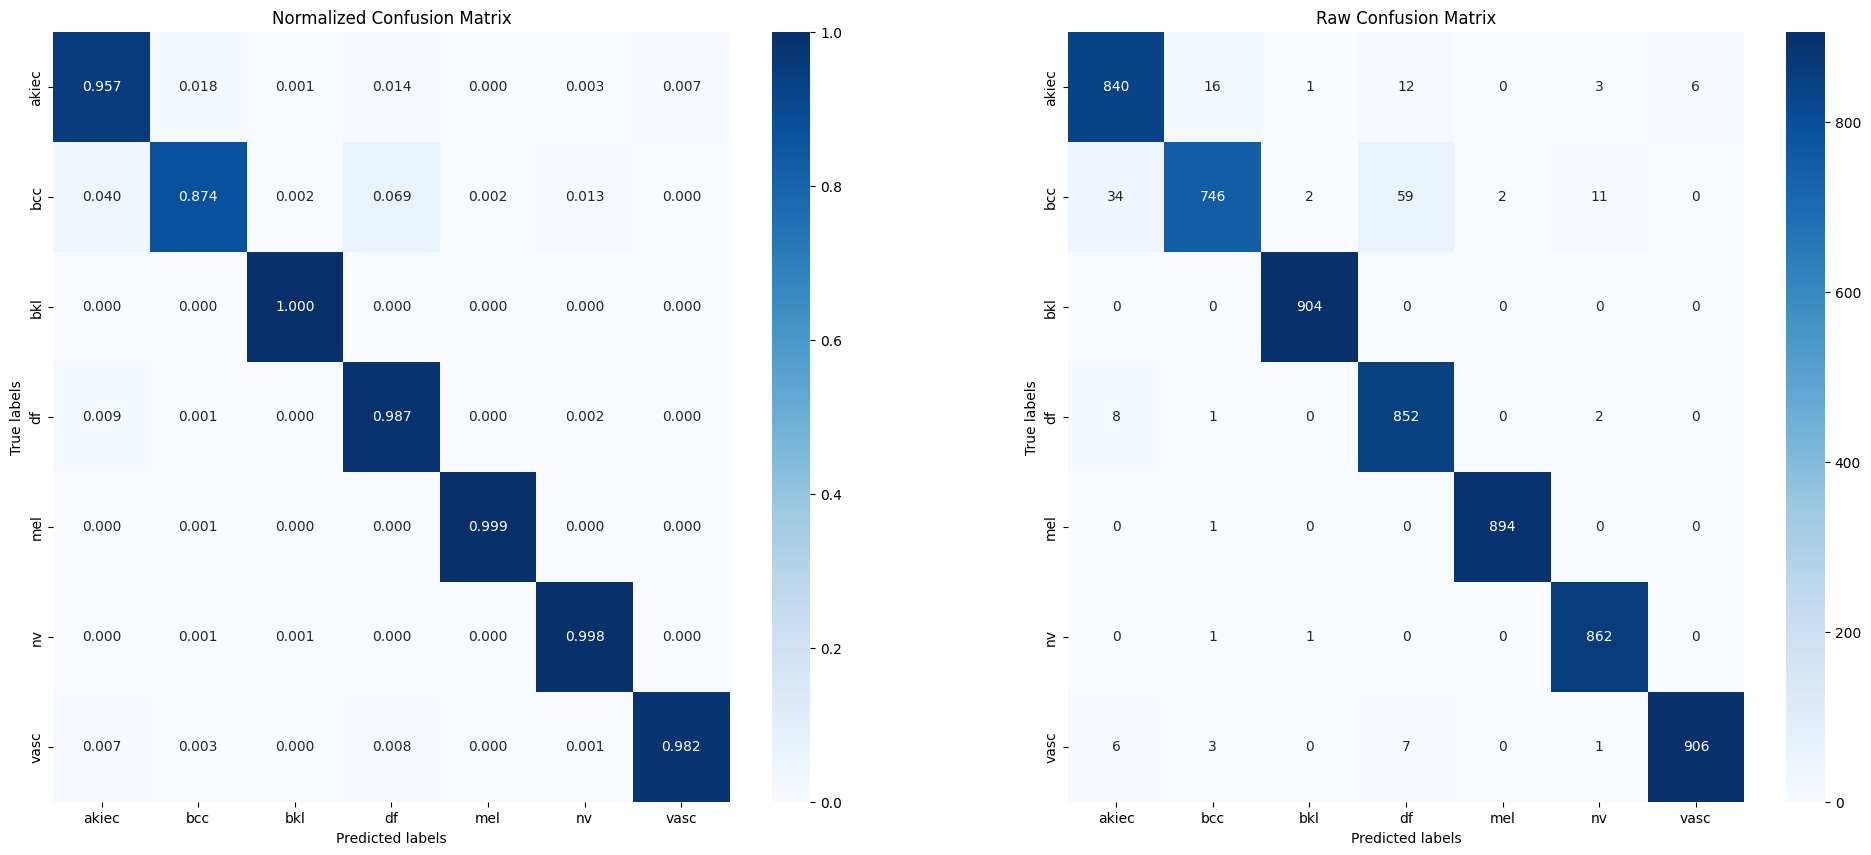

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

       akiec       0.95      0.96      0.95       878
         bcc       0.97      0.87      0.92       854
         bkl       1.00      1.00      1.00       904
          df       0.92      0.99      0.95       863
         mel       1.00      1.00      1.00       895
          nv       0.98      1.00      0.99       864
        vasc       0.99      0.98      0.99       923

    accuracy                           0.97      6181
   macro avg       0.97      0.97      0.97      6181
weighted avg       0.97      0.97      0.97      6181

-------------------------------------------------------


In [15]:
Model_functions.conf_report(densenet_model, test_loader, 'densenet_conf_mat')
# Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')

In [20]:
best_model_state = torch.load('densenet_pret.pth')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 96.90988513185569
-------------------------------------------------------
